## **Libraries**

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import numpy as np
import joblib

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


## **Import Dataset**

In [10]:
df=pd.read_csv("mbti_dataset.csv")

In [11]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## **Preprocessing data**

In [12]:
df["target_EI"]=df["type"].apply(lambda row: row[0])
df["target_NS"]=df["type"].apply(lambda row: row[1])
df["target_TF"]=df["type"].apply(lambda row: row[2])
df["target_PJ"]=df["type"].apply(lambda row: row[3])

In [13]:
df.head()

,type,posts,target_EI,target_NS,target_TF,target_PJ
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J


In [14]:
y1=[]
y2=[]
barWidth = 0.4
r1 = range(len(y1))
r2 = [x + barWidth for x in r1]

In [15]:
y1.append(df["target_EI"].value_counts()[0])
y2.append(df["target_EI"].value_counts()[1])

In [16]:
y1.append(df["target_NS"].value_counts()[0])
y2.append(df["target_NS"].value_counts()[1])

In [17]:
y1.append(df["target_TF"].value_counts()[0])
y2.append(df["target_TF"].value_counts()[1])

In [18]:
y1.append(df["target_PJ"].value_counts()[0])
y2.append(df["target_PJ"].value_counts()[1])

Text(0.5, 1.0, 'Category P/J')

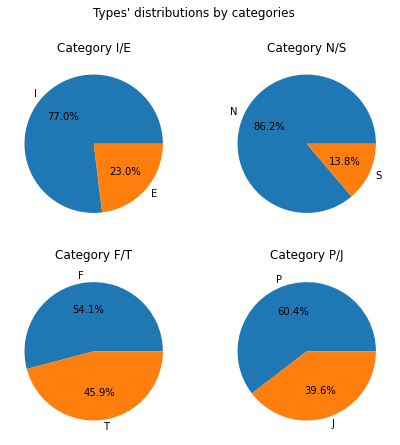

In [19]:
fig,ax = plt.subplots(2,2,figsize=(7,7))
fig.suptitle("Types' distributions by categories")
ax[0, 0].pie([y1[0],y2[0]], labels = ['I', 'E'],autopct='%1.1f%%')
ax[0, 0].set_title('Category I/E')
ax[0, 1].pie([y1[1],y2[1]], labels = ['N', 'S'],autopct='%1.1f%%')
ax[0, 1].set_title('Category N/S')
ax[1, 0].pie([y1[2],y2[2]], labels = ['F', 'T'],autopct='%1.1f%%')
ax[1, 0].set_title('Category F/T')
ax[1, 1].pie([y1[3],y2[3]], labels = ['P', 'J'],autopct='%1.1f%%')
ax[1, 1].set_title('Category P/J')

Categories FT and PJ are quite balanced. Accurracy will be adequate.
However, types E and S are underrepresented in their respective categories, so f1_score will be better these categories.

### **Clean Data**

In [20]:
stop_words = stopwords.words("english")
#create an object of class PorterStemmer
porter = PorterStemmer()

In [21]:
def cleanData(posts):
    # Lowercase
    clean_text = posts.lower()
    #remove all hyperlinks
    clean_text = re.sub(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})','',clean_text)
    word_list = word_tokenize(clean_text)
    clean_posts = []
    for word in word_list:
        if word.isalpha() and word not in stop_words:
            word = porter.stem(word)
            clean_posts.append(word)
    return clean_posts


In [22]:
df["posts_preprocessed"]= df["posts"].apply(lambda row: cleanData(row))

## **Models**

### **Vectorization**

In [23]:
cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [24]:
X=df["posts_preprocessed"].map(' '.join)

In [25]:
cnt_vector = cv.fit_transform(X)
tfidf_vector = tfidf.fit_transform(X)

In [26]:
vectors={'cnt_vector':cnt_vector,'tfidf_vector':tfidf_vector}

In [27]:
X_train_EI,X_test_EI,y_train_EI,y_test_EI = train_test_split(cnt_vector,df["target_EI"],test_size=0.2)


### **Predictions**

We will test the following classifiers for each category:
 * RandomForestClassifier
 * GaussianNb
 * MultinomialNB
 * LinearSVC
 * LogisticRegression

In [28]:
classifiers = [
    RandomForestClassifier(),
    GaussianNB(),
    MultinomialNB(),
    LinearSVC(dual=False),
    LogisticRegression(max_iter=1000,solver='liblinear')
    ]

**EI category**:

In [29]:

EI_f1_scores={}
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_EI"],test_size=0.2)
    for classifier in classifiers:
        if str(classifier) == "GaussianNB()":
            X_train=X_train.todense()
            X_test=X_test.todense()
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        f1=metrics.f1_score(y_test,predictions,zero_division=0,average='macro')
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        model_name = i +"+"+str(classifier)
        model_name_clean = re.sub(r'\([^)]*\)', '', model_name) #delete text within parentheses
        EI_f1_scores[model_name_clean]=f1
        print(model_name)
        print(classification)


cnt_vector+RandomForestClassifier()
              precision    recall  f1-score   support

           E       0.00      0.00      0.00       390
           I       0.78      1.00      0.87      1345

    accuracy                           0.78      1735
   macro avg       0.39      0.50      0.44      1735
weighted avg       0.60      0.78      0.68      1735

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           E       0.28      0.14      0.18       390
           I       0.78      0.90      0.84      1345

    accuracy                           0.73      1735
   macro avg       0.53      0.52      0.51      1735
weighted avg       0.67      0.73      0.69      1735

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           E       0.52      0.30      0.38       390
           I       0.82      0.92      0.87      1345

    accuracy                           0.78      1735
   macro avg       0.67      0.61      0.

**NS category:**

In [30]:
NS_f1_scores ={}
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_NS"],test_size=0.2)
    for classifier in classifiers:
        if str(classifier) == "GaussianNB()":
            X_train=X_train.todense()
            X_test=X_test.todense()
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        f1=metrics.f1_score(y_test,predictions,zero_division=0,average='macro')
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        model_name = i +"+"+str(classifier)
        model_name_clean = re.sub(r'\([^)]*\)', '', model_name) #delete text within parentheses
        NS_f1_scores[model_name_clean]=f1
        print(model_name)
        print(classification)

cnt_vector+RandomForestClassifier()
              precision    recall  f1-score   support

           N       0.86      1.00      0.93      1500
           S       0.00      0.00      0.00       235

    accuracy                           0.86      1735
   macro avg       0.43      0.50      0.46      1735
weighted avg       0.75      0.86      0.80      1735

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           N       0.87      0.98      0.92      1500
           S       0.16      0.03      0.04       235

    accuracy                           0.85      1735
   macro avg       0.51      0.50      0.48      1735
weighted avg       0.77      0.85      0.80      1735

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           N       0.88      0.98      0.92      1500
           S       0.43      0.11      0.18       235

    accuracy                           0.86      1735
   macro avg       0.65      0.54      0.

**TF category:**

In [31]:
TF_acc={}
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_TF"],test_size=0.2)
    for classifier in classifiers:
        if str(classifier) == "GaussianNB()":
            X_train=X_train.todense()
            X_test=X_test.todense()
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        acc=metrics.accuracy_score(y_test,predictions)
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        model_name = i +"+"+str(classifier)
        model_name_clean = re.sub(r'\([^)]*\)', '', model_name) #delete text within parentheses
        TF_acc[model_name_clean]=acc
        print(model_name)
        print(classification)
        


cnt_vector+RandomForestClassifier()
              precision    recall  f1-score   support

           F       0.73      0.88      0.80       934
           T       0.82      0.63      0.71       801

    accuracy                           0.76      1735
   macro avg       0.78      0.75      0.75      1735
weighted avg       0.77      0.76      0.76      1735

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           F       0.60      0.52      0.56       934
           T       0.52      0.60      0.55       801

    accuracy                           0.56      1735
   macro avg       0.56      0.56      0.56      1735
weighted avg       0.56      0.56      0.56      1735

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           F       0.81      0.83      0.82       934
           T       0.79      0.77      0.78       801

    accuracy                           0.80      1735
   macro avg       0.80      0.80      0.

**PJ category:**

In [32]:
PJ_acc={}
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_PJ"],test_size=0.2)
    for classifier in classifiers:
        if str(classifier) == "GaussianNB()":
            X_train=X_train.todense()
            X_test=X_test.todense()
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        acc=metrics.accuracy_score(y_test,predictions)
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        model_name = i +"+"+str(classifier)
        model_name_clean = re.sub(r'\([^)]*\)', '', model_name) #delete text within parentheses
        PJ_acc[model_name_clean]=acc
        print(model_name)
        print(classification)

cnt_vector+RandomForestClassifier()
              precision    recall  f1-score   support

           J       0.91      0.16      0.27       709
           P       0.63      0.99      0.77      1026

    accuracy                           0.65      1735
   macro avg       0.77      0.58      0.52      1735
weighted avg       0.75      0.65      0.57      1735

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           J       0.46      0.43      0.44       709
           P       0.62      0.64      0.63      1026

    accuracy                           0.56      1735
   macro avg       0.54      0.54      0.54      1735
weighted avg       0.55      0.56      0.55      1735

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           J       0.70      0.57      0.63       709
           P       0.74      0.84      0.78      1026

    accuracy                           0.73      1735
   macro avg       0.72      0.70      0.

As said before, we have to look at precision for JP category. It seems that tfidf_vector() + LinearSVC() fit better the category

In [33]:
print(list(EI_f1_scores.keys())[0])

cnt_vector+RandomForestClassifier


### **Analysis of models**

We will compare the differents models for each category.
As seen before, for the categories E/I and N/S we are interesting in f1_score results. For T/F and P/J, we are focus on accuracy.

Text(0.5, 1.0, "models' accuracies for P/J category")

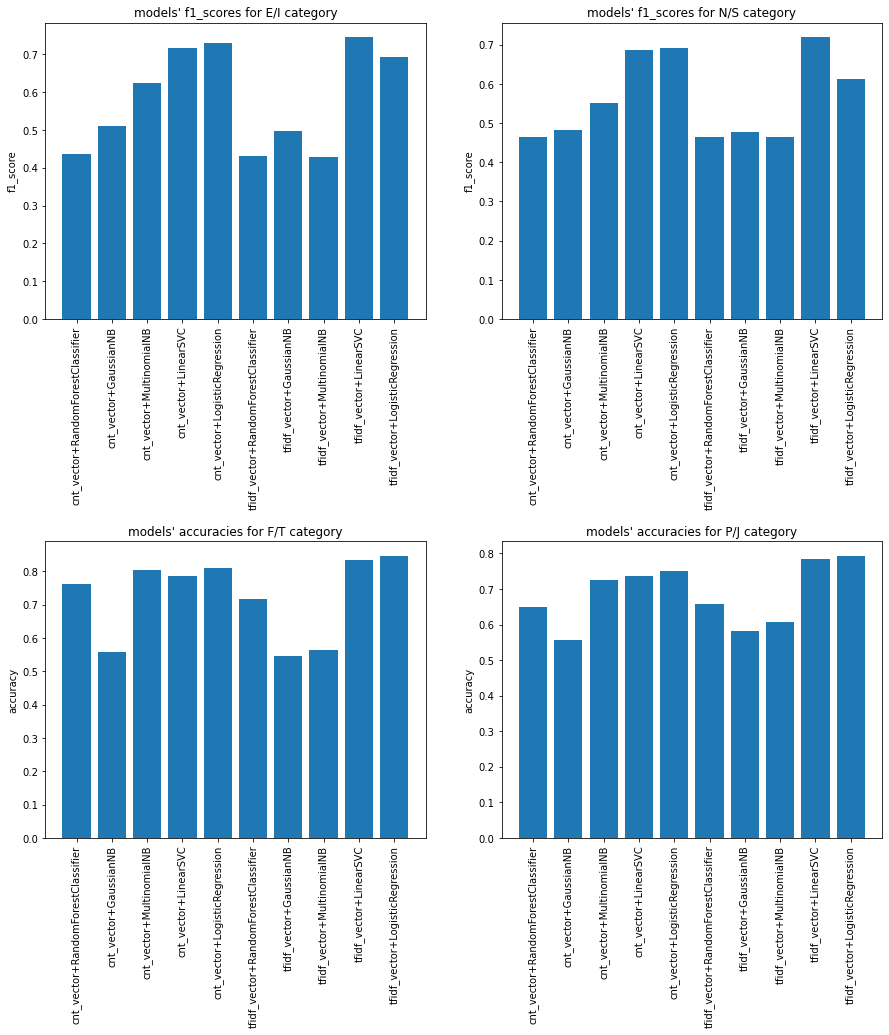

In [34]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
fig.subplots_adjust(hspace=0.75)

ax[0, 0].bar(range(len(EI_f1_scores)),list(EI_f1_scores.values()), align='center')
ax[0, 0].set_xticks(range(len(EI_f1_scores)))
ax[0, 0].set_xticklabels([list(EI_f1_scores.keys())[x] for x in range(len(EI_f1_scores))], rotation=90)
ax[0, 0].set_ylabel("f1_score")
ax[0, 0].set_title("models' f1_scores for E/I category")

ax[0, 1].bar(range(len(NS_f1_scores)), list(NS_f1_scores.values()), align='center')
ax[0, 1].set_xticks(range(len(NS_f1_scores)))
ax[0, 1].set_xticklabels([list(NS_f1_scores.keys())[x] for x in range(len(NS_f1_scores))], rotation=90)
ax[0, 1].set_ylabel("f1_score")
ax[0, 1].set_title("models' f1_scores for N/S category")

ax[1, 0].bar(range(len(TF_acc)), list(TF_acc.values()), align='center')
ax[1, 0].set_xticks(range(len(TF_acc)))
ax[1, 0].set_xticklabels([list(TF_acc.keys())[x] for x in range(len(TF_acc))], rotation=90)
ax[1, 0].set_ylabel("accuracy")
ax[1, 0].set_title("models' accuracies for F/T category")

ax[1, 1].bar(range(len(PJ_acc)), list(PJ_acc.values()), align='center')
ax[1, 1].set_xticks(range(len(PJ_acc)))
ax[1, 1].set_xticklabels([list(PJ_acc.keys())[x] for x in range(len(PJ_acc))], rotation=90)
ax[1, 1].set_ylabel("accuracy")
ax[1, 1].set_title("models' accuracies for P/J category")

**As we can see on the bar charts above, tfidf_vector+LinearSVC() is the model which fit well all the categories.**

## **Exporting models**

In [36]:
pipe = Pipeline([
        ('vector', TfidfVectorizer()),
        ('regressor', LinearSVC(dual=False))
        ])

In [47]:
X_train_EI,X_test_EI,y_train_EI,y_test_EI = train_test_split(X,df["target_EI"],test_size=0.2)
model_EI = pipe.fit(X_train_EI, y_train_EI)
joblib.dump(model_EI, "joblib_model_EI.pkl")

['joblib_model_EI.pkl']

In [48]:
X_train_NS,X_test_NS,y_train_NS,y_test_NS = train_test_split(X,df["target_NS"],test_size=0.2)
model_NS = pipe.fit(X_train_NS, y_train_NS)
joblib.dump(model_NS, "joblib_model_NS.pkl")

['joblib_model_NS.pkl']

In [49]:
X_train_TF,X_test_TF,y_train_TF,y_test_TF= train_test_split(X,df["target_TF"],test_size=0.2)
model_TF = pipe.fit(X_train_TF, y_train_TF)
joblib.dump(model_TF, "joblib_model_TF.pkl")

['joblib_model_TF.pkl']

In [50]:
X_train_PJ,X_test_PJ,y_train_PJ,y_test_PJ= train_test_split(X,df["target_PJ"],test_size=0.2)
model_PJ = pipe.fit(X_train_PJ, y_train_PJ)
joblib.dump(model_PJ, "joblib_model_TF.pkl")

['joblib_model_TF.pkl']